# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.image as mpimg
import sklearn.preprocessing as pp
import random
import cv2
import matplotlib.pyplot as plt
import csv
from PIL import Image, ImageOps
from ipywidgets import interact, fixed
%matplotlib inline 

---
## Step 0: Load The Data

In [2]:
import pickle

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_test[58].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
""" First, let's take a look at some of the images and what their labels look like: """

sign_names = {}
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         sign_names[row[0]] = row[1]

def show_sign_at_index(i, images, classifications):
    img = images[i]
    sign_prediction = classifications[i]
    print(str(sign_prediction) + ":  " + sign_names[str(sign_prediction)])
    plt.axis('off')
    plt.imshow(img)
    plt.show();
    print(img.shape)

12:  Priority road


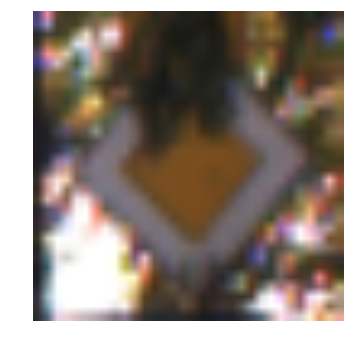

(32, 32, 3)


In [5]:
interact(show_sign_at_index, i=(0,len(X_train)), classifications=fixed(y_train), images = fixed(X_train));

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

##### Preprocessing

In [6]:
def rgb_to_normalized_gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray/255. - 0.5

def normalize(imgs):
    imgs = np.array(imgs, dtype=np.float64)
    return imgs/255. - 0.5

In [7]:
X_train_batches_gray = []
X_train_batches_color = []
y_train_batches = []

perm = np.random.permutation(len(X_train))[:40*980]
perm = perm.reshape((40,980))

images_gray = np.array([rgb_to_normalized_gray(image) for image in X_train])
images_color = normalize(X_train)

for j in range(40):
    x_train_batch_gray = images_gray[perm[j]]
    x_train_batch_color = images_color[perm[j]]
    y_train_batch = y_train[perm[j]]
    
    X_train_batches_gray.append(x_train_batch_gray)
    X_train_batches_color.append(x_train_batch_color)
    y_train_batches.append(y_train_batch)

In [8]:
X_validation_gray =  np.array([rgb_to_normalized_gray(image) for image in X_test])[7500:]
X_validation_color =  normalize(X_test)[7500:]
y_validation = y_test[7500:]

X_test_gray =  np.array([rgb_to_normalized_gray(image) for image in X_test])[:7500]
X_test_color =  normalize(X_test)[:7500]
y_test = y_test[:7500]

##### Data Augmentation (credit: Vivek Yadav)

In [9]:
def transform_image(img,ang_range,shear_range,trans_range, reduction_coeff):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    ang_range*=reduction_coeff
    shear_range*=reduction_coeff
    trans_range*=reduction_coeff
    
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    
    rows,cols, colours = 0,0,0
    if len(img.shape) == 2:
        rows,cols = img.shape
    else:
        rows,cols, colours = img.shape
        
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    # Brightness Variation
    
    if len(img.shape) == 3:
        value = np.random.uniform(high=100.) - 50
        value*=reduction_coeff
        coef = 1
        if value < -1:
            coef = -1
            value = abs(value)

        value = np.array(value, dtype=np.uint8)

        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
        if coef == 1:
            hsv[:,:,2] = np.where((255 - hsv[:,:,2]) < value,255,hsv[:,:,2]+value)
        else:
            hsv[:,:,2] = np.where( hsv[:,:,2] < value,0,hsv[:,:,2]-value)
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return img

# Architecture

### Sermanet Model (Sermanet Team, LeCun paper)

In [10]:
def conv2d(name, l_input, w, b):
    return tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b), name=name)

def max_pool(name, l_input, k, stride):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], 
                          padding='SAME', name=name)

def serma_net(_X, _weights, _biases, _dropout):
    
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 32, 32, 1])
    
    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=2, stride=2)
    
    # Apply Dropout
    conv1_out = tf.nn.dropout(pool1, _dropout)
    
    # Convolution Layer
    conv2 = conv2d('conv2', conv1_out, _weights['wc2'], _biases['bc2'])
    
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=2, stride=2)
    
    # Apply Dropout
    conv2_out = tf.nn.dropout(pool2, _dropout)
    
    # Max Pooling (down-sampling) applied to the first convolutional layer
    conv1_bridge = max_pool('pool1', conv1_out, k=5, stride=3)
    
    # Fully connected layer
    flat1 = tf.contrib.layers.flatten(conv1_bridge)
    flat2 = tf.contrib.layers.flatten(conv2_out)
    concat = tf.concat(1, [flat1, flat2])
    dense1 = tf.contrib.layers.flatten(concat)
    
    # Elu activation
    dense1 = tf.nn.elu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    dense1 = tf.nn.dropout(dense1, _dropout)
                       
    # Output, class prediction
    out = tf.matmul(dense1, _weights['out']) + _biases['out']
    return out

###### Tensorflow Graph 1

In [11]:
tf.reset_default_graph()

g1 = tf.Graph()
with g1.as_default() as g:
    with g.name_scope("EBLearn") as g1_scope:
        
        # Parameters
        learning_rate = 0.001
        n_input = 32*32*1 # Traffic Signs data input (img shape)
        n_classes = 43 # Traffic Signs total classes (43 different types of signs)
        dropout = 0.5 # Dropout
        
        # Input Placeholders
        EB_x = tf.placeholder(tf.float32, [None, 32, 32])
        EB_y = tf.placeholder(tf.float32, [None, n_classes])
        EB_keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

        #Model Weights & Biases
        EB_weights = {
            'wc1': tf.get_variable("conv1_w", shape=[5, 5, 1, 108], initializer=tf.contrib.layers.xavier_initializer()),
            'wc2': tf.get_variable("conv2_w", shape=[5, 5, 108, 108], initializer=tf.contrib.layers.xavier_initializer()),
            'wd1': tf.get_variable("dense1_w", shape=[10800, 100], initializer=tf.contrib.layers.xavier_initializer()),
            'out': tf.get_variable("out_w", shape=[100, n_classes], initializer=tf.contrib.layers.xavier_initializer())
        }
        EB_biases = {
            'bc1': tf.get_variable("conv1_b", shape=[108], initializer=tf.contrib.layers.xavier_initializer()),
            'bc2': tf.get_variable("conv2_b", shape=[108], initializer=tf.contrib.layers.xavier_initializer()),

            'bd1': tf.get_variable("dense1_b", shape=[100], initializer=tf.contrib.layers.xavier_initializer()),
            'bd2': tf.get_variable("dense2_b", shape=[1024], initializer=tf.contrib.layers.xavier_initializer()),

            'out': tf.get_variable("out_b", shape=[n_classes], initializer=tf.contrib.layers.xavier_initializer())
        }

        # Loss
        EB_model_output = serma_net(EB_x, EB_weights, EB_biases, EB_keep_prob)
        EB_prediction = tf.nn.softmax(EB_model_output)
        EB_cross_entropy = -tf.reduce_sum(EB_y * tf.log(EB_prediction + 1e-6), reduction_indices=1)
        EB_cost = tf.reduce_mean(EB_cross_entropy)

        # Optimization
        EB_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(EB_cost)

        # Model Evaluation
        EB_correct_pred = tf.equal(tf.argmax(EB_prediction,1), tf.argmax(EB_y,1))
        EB_accuracy = tf.reduce_mean(tf.cast(EB_correct_pred, tf.float32))

#### Training SermaNet

In [ ]:
with tf.Session(graph = g1) as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    saver.restore(sess, "./SERMANET.ckpt")
    
    current_X_train_batches = X_train_batches_gray

    for step in range(100):
        print("Iteration "+str(step))
        for i in range(40):
            # Further Split the batches due to memory constraints
            for j in range(20):
                
                batch_xs = current_X_train_batches[i][49*j:49*(j+1)]
                batch_ys = tf.one_hot(y_train_batches[i][49*j:49*(j+1)], n_classes).eval(session=sess)
                
                # Fit training using batch data
                sess.run(EB_optimizer, feed_dict={EB_x: batch_xs, EB_y: batch_ys, EB_keep_prob: dropout})

                # Accuracy & Loss
                acc = sess.run(EB_accuracy, feed_dict={EB_x: batch_xs, EB_y: batch_ys, EB_keep_prob: 1.})
                loss = sess.run(EB_cost, feed_dict={EB_x: batch_xs, EB_y: batch_ys, EB_keep_prob: 1.})

                print("Batch " + str(i) + ", Minibatch Loss= " \
                          + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))

                
        save_path = saver.save(sess, "./SERMANET.ckpt")
        print("Model saved in file: %s" % save_path)
        
        #Test Set performance:
        test_accuracy = []
        test_loss = []
        
        for i in range(20):
            test_xs = X_test_gray[50*j:50*(j+1)]
            test_ys = tf.one_hot(y_test[i*50:(i+1)*50], n_classes).eval(session=sess)
            
            acc = sess.run(EB_accuracy, feed_dict={EB_x: test_xs, EB_y: test_ys, EB_keep_prob:1.})
            loss = sess.run(EB_cost, feed_dict={EB_x: test_xs, EB_y: test_ys, EB_keep_prob: 1.})
        
            test_accuracy.append(acc)
            test_loss.append(loss)
            
        print("Test Set Accuracy:  " + str(np.mean(test_accuracy)) + \
              ", Loss: " + str(np.mean(test_loss)))

        # Augmented data generation:
        reduction_coefficient = 0.9**(step-10)
        current_X_train_batches = normalize([[transform_image(np.array((image+0.5)*255, dtype=np.uint8),10,5,3,reduction_coefficient) for image in batch] for batch in X_train_batches_gray])

#### SermaNet Validation

In [12]:
with tf.Session(graph = g1) as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    saver.restore(sess, "./SERMANET.ckpt")
    
    validation_accuracy = []
    
    # Split up the validation set due to memory restrictions.
    for i in range(100):
        test_ys = tf.one_hot(y_validation[i*50:(i+1)*50], n_classes).eval(session=sess)
        acc = sess.run(EB_accuracy, feed_dict={EB_x: X_validation_gray[i*50:(i+1)*50], EB_y: test_ys, EB_keep_prob:1.})
        validation_accuracy.append(acc)
        
    print("Validation Accuracy for SermaNet:" + str(np.mean(validation_accuracy)))

Validation Accuracy for SermaNet:0.9454


### Alexnet-based Model

In [13]:
def conv2d(name, l_input, w, b):
    return tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b), name=name)

def max_pool(name, l_input, k, stride=1):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

def alex_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 32, 32, 3])

    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=3, stride=3)
    # Apply Normalization
    norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    norm1 = tf.nn.dropout(norm1, _dropout)

    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=3, stride=3)
    # Apply Normalization
    norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    pool3 = max_pool('pool3', conv3, k=3, stride=3)
    # Apply Normalization
    norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    norm3 = tf.nn.dropout(norm3, _dropout)
    
    # Fully Connected Layers
    dense1 = tf.reshape(norm3, [-1, _weights['wd1'].get_shape().as_list()[0]])
    dense1 = tf.nn.elu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    dense1 = tf.nn.dropout(dense1, _dropout)
    
    dense2 = tf.nn.elu(tf.matmul(dense1, _weights['wd2']), name='fc2')
    dense2 = dense2  + _biases['bd2']
    dense2 = tf.nn.dropout(dense2, _dropout)
    
    # Output, class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out

###### Tensorflow Graph 2

In [14]:
g2 = tf.Graph()
with g2.as_default() as g:
    with g.name_scope("AlexNet") as g2_scope:
        
        # Parameters
        learning_rate = 0.001
        n_input = 32*32*3 # Traffic Signs data input (img shape)
        n_classes = 43 # Traffic Signs total classes (43 different types of signs)
        dropout = 0.5 # Dropout
        
        # Input Placeholders
        AN_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        AN_y = tf.placeholder(tf.float32, [None, n_classes])
        AN_keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

        #Model Weights & Biases
        AN_weights = {
            'wc1': tf.get_variable("conv1_w", shape=[3, 3, 3, 32], initializer=tf.contrib.layers.xavier_initializer()),
            'wc2': tf.get_variable("conv2_w", shape=[3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer()),
            'wc3': tf.get_variable("conv3_w", shape=[3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer()),
            
            'wd1': tf.get_variable("dense1_w", shape=[512, 1024], initializer=tf.contrib.layers.xavier_initializer()),
            'wd2': tf.get_variable("dense2_w", shape=[1024, 1024], initializer=tf.contrib.layers.xavier_initializer()),

            'out': tf.get_variable("out_w", shape=[1024, n_classes], initializer=tf.contrib.layers.xavier_initializer())
        }
    
        AN_biases = {
        'bc1': tf.get_variable("conv1_b", shape=[32], initializer=tf.contrib.layers.xavier_initializer()),
        'bc2': tf.get_variable("conv2_b", shape=[64], initializer=tf.contrib.layers.xavier_initializer()),
        'bc3': tf.get_variable("conv3_b", shape=[128], initializer=tf.contrib.layers.xavier_initializer()),
    
        'bd1': tf.get_variable("dense1_b", shape=[1024], initializer=tf.contrib.layers.xavier_initializer()),
            'bd2': tf.get_variable("dense2_b", shape=[1024], initializer=tf.contrib.layers.xavier_initializer()),
    
            'out': tf.get_variable("out_b", shape=[n_classes], initializer=tf.contrib.layers.xavier_initializer())
        }

        # Loss
        AN_model_output = alex_net(AN_x, AN_weights, AN_biases, AN_keep_prob)
        AN_prediction = tf.nn.softmax(AN_model_output)
        AN_cross_entropy = -tf.reduce_sum(AN_y * tf.log(AN_prediction + 1e-6), reduction_indices=1)
        AN_cost = tf.reduce_mean(AN_cross_entropy)

        # Optimization
        AN_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(AN_cost)

        # Model Evaluation
        AN_correct_pred = tf.equal(tf.argmax(AN_prediction,1), tf.argmax(AN_y,1))
        AN_accuracy = tf.reduce_mean(tf.cast(AN_correct_pred, tf.float32))

tf.reset_default_graph()

#### Training AlexNet

In [ ]:
with tf.Session(graph = g2) as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    saver.restore(sess, "./ALEXNET.ckpt")
    
    current_X_train_batches = X_train_batches_color
    
    for step in range(100):
        print("Iteration "+str(step))
        for i in range(40):
            # Fit training using batch data
            
            for j in range(20):
                batch_xs = current_X_train_batches[i][49*j:49*(j+1)]
                batch_ys = tf.one_hot(y_train_batches[i][49*j:49*(j+1)], n_classes).eval(session=sess)
                
                sess.run(AN_optimizer, feed_dict={AN_x: batch_xs, AN_y: batch_ys, AN_keep_prob: dropout})

                acc = sess.run(AN_accuracy, feed_dict={AN_x: batch_xs, AN_y: batch_ys, AN_keep_prob: 1.})
                loss = sess.run(AN_cost, feed_dict={AN_x: batch_xs, AN_y: batch_ys, AN_keep_prob: 1.})

                print("Batch " + str(j) + ", Minibatch Loss= " \
                          + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))

        if step%10 == 0:
            save_path = saver.save(sess, "./ALEXNET"+str(step)+".ckpt")
            print("Model saved in file: %s" % save_path)

            
        #Test Set performance:
        
        test_accuracy = []
        test_loss = []
        for j in range(20):
            test_xs = X_test_color[50*j:50*(j+1)]
            test_ys = tf.one_hot(y_test[j*50:(j+1)*50], n_classes).eval(session=sess)
            
            acc = sess.run(AN_accuracy, feed_dict={AN_x: test_xs, AN_y: test_ys, AN_keep_prob:1.})
            loss = sess.run(AN_cost, feed_dict={AN_x: test_xs, AN_y: test_ys, AN_keep_prob: 1.})
        
            print(acc)
            test_accuracy.append(acc)
            test_loss.append(loss)
            
        print("Test Set Accuracy:  " + str(np.mean(test_accuracy)) + \
              ", Loss: " + str(np.mean(test_loss)))
        
        # Augmented data generation:
        reduction_coefficient = 1
        if step > 10:
            reduction_coefficient = 0.9**(step-10)
        current_X_train_batches = normalize([[transform_image(np.array((image+0.5)*255, dtype=np.uint8),20*4,10*4,6*4,reduction_coefficient) for image in batch] for batch in X_train_batches_color])

###### Alexnet Validation

In [15]:
with tf.Session(graph = g2) as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    saver.restore(sess, "./ALEXNET.ckpt")
    
    validation_accuracy = []
    
    # Split up the validation set due to memory restrictions.
    for i in range(100):
        test_ys = tf.one_hot(y_validation[i*50:(i+1)*50], n_classes).eval(session=sess)
        acc = sess.run(AN_accuracy, feed_dict={AN_x: X_validation_color[i*50:(i+1)*50], AN_y: test_ys, AN_keep_prob:1.})
        validation_accuracy.append(acc)
        
    print("Validation Accuracy for AlexNet:" + str(np.mean(validation_accuracy)))

Validation Accuracy for AlexNet:0.9102


### Ensemble Model

In [16]:
def ensemble_classify(imgs):
    colour_imgs = normalize(imgs)
    gray_imgs = [rgb_to_normalized_gray(image) for image in imgs]
    
    with tf.Session(graph = g1) as sess:
        tf.global_variables_initializer().run()
        saver = tf.train.Saver()
        saver.restore(sess, "./SERMANET.ckpt")
        pred_1 = sess.run(EB_prediction, feed_dict={EB_x:gray_imgs, EB_keep_prob: 1.})
        
    with tf.Session(graph = g2) as sess:
        tf.global_variables_initializer().run()
        saver = tf.train.Saver()
        saver.restore(sess, "./ALEXNET.ckpt")
        pred_2 = sess.run(AN_prediction, feed_dict={AN_x:colour_imgs, AN_keep_prob: 1.})
        
    prediction = (pred_1 + pred_2)/2
    return prediction

#### Ensemble Model Accuracy on the Validation Set

In [ ]:
predictions = np.empty(shape=(0, 43))
    
for i in range(102):
    print("Batch "+str(i)+" of 102")
    pred = ensemble_classify((X_validation_color[i*50:(i+1)*50] + 0.5)*255)
    predictions = np.append(predictions, pred, axis=0)

Batch 0 of 102
Batch 1 of 102
Batch 2 of 102
Batch 3 of 102
Batch 4 of 102
Batch 5 of 102
Batch 6 of 102
Batch 7 of 102
Batch 8 of 102
Batch 9 of 102
Batch 10 of 102
Batch 11 of 102
Batch 12 of 102
Batch 13 of 102
Batch 14 of 102
Batch 15 of 102
Batch 16 of 102
Batch 17 of 102
Batch 18 of 102
Batch 19 of 102
Batch 20 of 102
Batch 21 of 102
Batch 22 of 102
Batch 23 of 102
Batch 24 of 102
Batch 25 of 102
Batch 26 of 102
Batch 27 of 102
Batch 28 of 102
Batch 29 of 102
Batch 30 of 102
Batch 31 of 102
Batch 32 of 102
Batch 33 of 102
Batch 34 of 102
Batch 35 of 102
Batch 36 of 102
Batch 37 of 102
Batch 38 of 102
Batch 39 of 102
Batch 40 of 102
Batch 41 of 102
Batch 42 of 102
Batch 43 of 102
Batch 44 of 102
Batch 45 of 102
Batch 46 of 102
Batch 47 of 102
Batch 48 of 102
Batch 49 of 102
Batch 50 of 102
Batch 51 of 102


In [ ]:
test_accuracy = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    y = tf.placeholder(tf.int32, [None])
    predicted_ys = tf.placeholder(tf.float32, [None, n_classes])
    actual_ys = tf.one_hot(y, n_classes)
    correct_pred = tf.equal(tf.argmax(predicted_ys,1), tf.argmax(actual_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    acc = sess.run(accuracy, feed_dict={predicted_ys: predictions, y: y_validation[:5100]})
    test_accuracy.append(acc)
    print("Ensemble Test Accuracy: "+str(acc*100)+"%")

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

Q1
<font color='red'>
I tried multiple normalisation techniques for this project, however I ultimately settled for the most simple of all: dividing each pixel value by 255 and subtracting 0.5 to center it around zero.
    <br>
The reason I settled for such a simple normalisation procedure is mostly for ease of use. Subtracting the mean of the image set and dividing by the standard deviation didn't make sense in this context, since it didn't provide any significant performance improvements and it creates difficulty when working with new images to classify.

<br>
<br>
Beyond normalisation, I also followed Dr. Vivek Yadav's guide on dataset augmentation, which helps to prevent overfitting on the small dataset provided, and helps generalise the model to many different angles. In addition to Dr. Yadav's tilting/shearing procedure, I did brightness variation, which helped to further generalise the dataset provided to many different lighting conditions.
<br>
My data augmentation is performed in my training routine, as it allows for fine grain control over the amount of change to the dataset at different stages in the training procedure. I gradually reduce the augmented dataset as training progresses, in order to allow the model to learn the more subtle features of the dataset.
</font> 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

<font color='red'>
I split my data into training, testing and validation sets.  As described above, I generated additional data within the train procedure itself.  The additional data consists of basic transformations of the training data, varying the rotation, translation and brightness in the images, in order to make the model more robust towards these changes. <br><br>
Augmenting the dataset reinforces the notion that the actual features of the traffic signs matter and not the conditions under which they were taken.  We hope that the model becomes invariant to the conditions in which the image is taken.
</font> 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

<font color='red'>
I started with a simple convolutional neural network, based on Alexnet. It consists of 3 3x3 convolution layers, each with a relu activation function. The convolution layers are each followed by a 3x3 max pooling layer, followed by normalisation and dropout.  The final convolutional layer is flattened into a fully connected layer, which is followed by another fully connected layer, from which we then gather the output values.  These are then converted to class predictions using a standard sigmoid function.  Overall, a standard convolutional model.
<br><br>
I then read tried to mimick the network proposed by Yann LeCun in the paper referenced above.  He describes a very simple 2-layer convolutional neural network submitted by the Sermanet team in the traffic sign classification competition. This conv-net consists of two convolutional layers, of size 108 each, both feeding into a single fully-connected layer of size 100.  I mimicked this approach above (Sermanet model).
<br><br>
I then tried to ensemble these conv-nets, which proved to yield better results than each conv-net on its own.  (See the 'ensemble_classify' method for the implementation).
</font> 

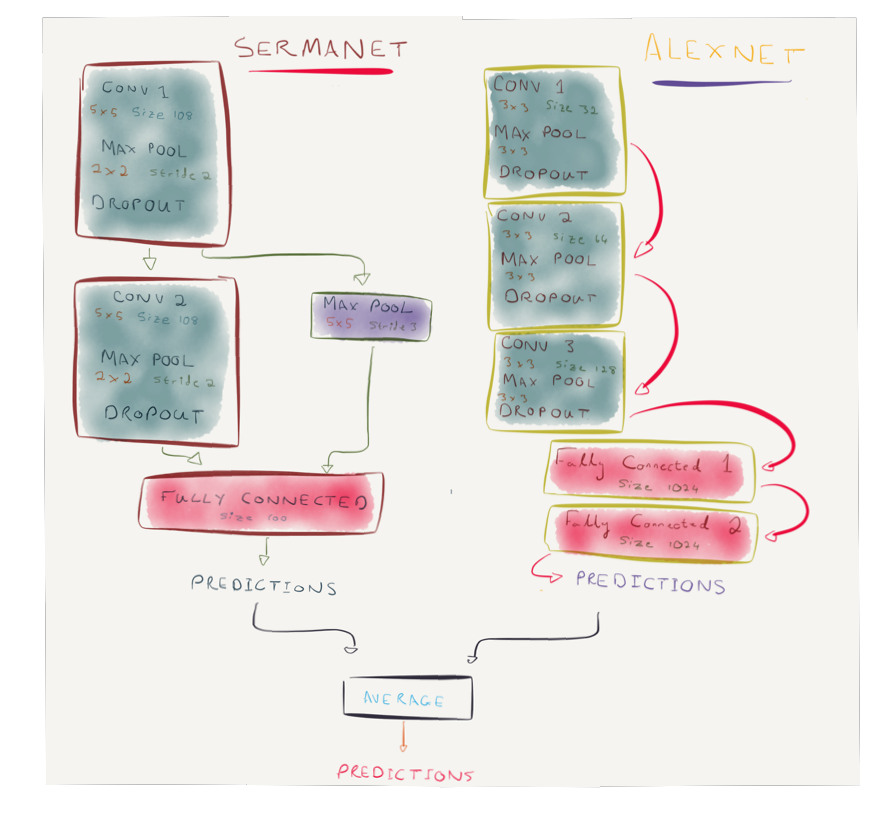

In [17]:
network_architecture_img = Image.open("./TrafficNet.png")
plt.figure(figsize=(20,10))
plt.imshow(network_architecture_img)
plt.axis('off')
plt.show();

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

<font color='red'>
For training the model, I used the well known and loved Adam Optimizer with a learning rate of 0.001.  My training data is split into 40 batches of 980 images each. 50 epochs seems to be more than enough to train this specific model on the training data provided.
</font> 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

<font color='red'>
I started out by trying to fully understand how convolutional neural networks operate. I also worked through a few tutorials on building convnets.  I then chose a base architecture -AlexNet in this case- and started to experiment with converting it to fit my traffic sign problem.
<br><br>
After having built, trained and tested a functional AlexNet model, I started looking to literature for a better performing architecture that I could implement to improve my validation results. I implemented a simplified version of the Sermanet team's convolutional neural network explained by Yann LeCun in his paper on the Traffic Sign Classifier project solutions (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).
<br><br>
I used this model to ensemble my own (I had gotten rather attached to my little AlexNet model, and I didn't just want to discard it in favour of a better model). The idea being that the Sermanet-clone would function on grayscale images, while the AlexNet would work with color images, allowing the ensemble to use color information without overfitting on it.
</font> 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

<font color='red'>
<strong>
The images below were fetched from a streetView drive around the Maximilaneum in Munich, and around the Breitscheidplatz in Berlin:
</strong>
</font> 

In [18]:
raw_images =[Image.open("./Breitscheidplatz/sign1.png"), \
            Image.open("./Breitscheidplatz/sign2.png"),  \
            Image.open("./Breitscheidplatz/sign3.png"),  \
            Image.open("./Breitscheidplatz/sign4.png"),  \
            Image.open("./Breitscheidplatz/sign6.png"),  \
            Image.open("./Breitscheidplatz/sign7.png"),  \
            Image.open("./Breitscheidplatz/sign8.png"),  \
            Image.open("./Breitscheidplatz/sign9.png"),  \
            Image.open("./Breitscheidplatz/sign10.png"), \
            Image.open("./Maximilaneum/sign1.png"),      \
            Image.open("./Maximilaneum/sign2.png"),      \
            Image.open("./Maximilaneum/sign3.png"),      \
            Image.open("./Maximilaneum/sign4.png"),      \
            Image.open("./Maximilaneum/sign5.png"),      \
            Image.open("./Maximilaneum/sign7.png"),      \
            Image.open("./Maximilaneum/sign8.png"),      \
            Image.open("./Maximilaneum/sign9.png"),      \
            Image.open("./Maximilaneum/sign10.png"),     \
            Image.open("./Maximilaneum/sign11.png"),     \
            Image.open("./Maximilaneum/sign12.png"),     \
            Image.open("./Maximilaneum/sign13.png"),     \
            Image.open("./Maximilaneum/sign14.png")]

maximilaneum_signs = []
streetview_signs = []

for image in raw_images:
    streetview_signs.append(np.asarray(ImageOps.fit(image, (32,32), Image.ANTIALIAS)))

streetview_classifications = ensemble_classify(streetview_signs)

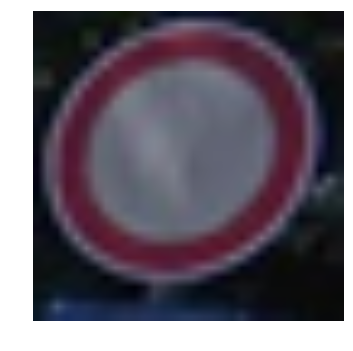

1: No vechiles
2: End of all speed and passing limits
3: Speed limit (80km/h)
4: Speed limit (30km/h)
5: Speed limit (50km/h)


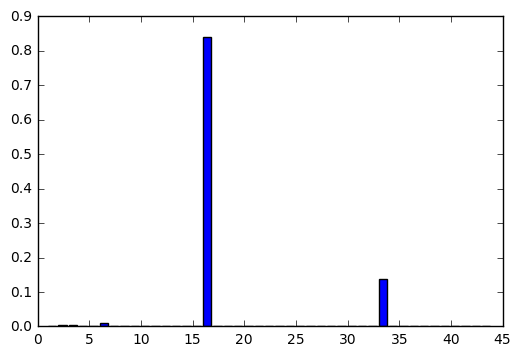

In [19]:
def show_sign_at_index(i, images, classifications):
    img = images[i]
    sign_prediction = classifications[i]
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
    sorted_classification = np.argsort(sign_prediction)[::-1][:5]
    for j in range(len(sorted_classification)):
        print(str(j+1) + ": " + sign_names[str(sorted_classification[j])])
    
    fig = plt.figure()
    plt.bar( np.arange(1, 44), sign_prediction )
    plt.show()

interact(show_sign_at_index, i=(0,len(streetview_classifications)-1), classifications=fixed(streetview_classifications), images = fixed(streetview_signs));

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

## <font color='red'> #1: Misclassification: "Children Crossing" classified as "Road Work"
</font>

<font color='red'>
The image below was classified as "Road work", rather than "Children Crossing".  When looking at the scaled-down image, it's easy to see why. This suggests that it might help in future to train the model on a higher definition set of images (or reduce the size of the cropping region). What's encouraging though, is that the network clearly indicates that it is uncertain, giving the classification a p-value below 0.5. In practice we might reject classifications with low p-values, try grab another image from the video and try to classify the image again.
</font>

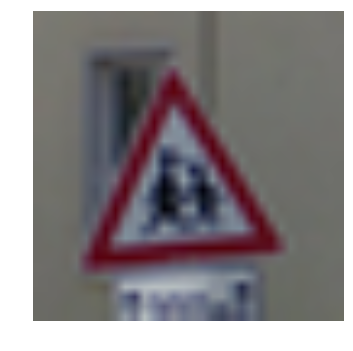

1: Road work
2: Beware of ice/snow
3: Bicycles crossing
4: Children crossing
5: Wild animals crossing


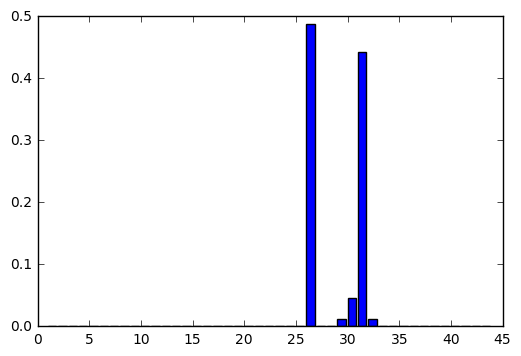

In [20]:
show_sign_at_index(16, classifications=streetview_classifications, images=streetview_signs)

## <font color='red'> #2: Correct Classification: 60 km/h Speed Limit
</font>

<font color='red'>
The 60km/h speed limit sign below, however classified correctly, reveals a lot about the classification procedure. It's encouraging to see that the top 5 are all speed limit signs (which are all visually similar).
</font>

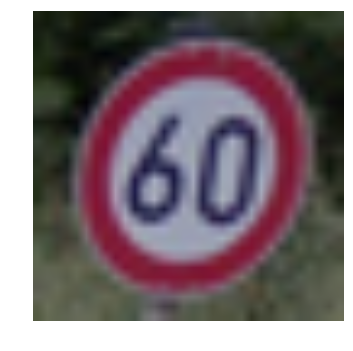

1: Speed limit (60km/h)
2: Speed limit (80km/h)
3: Speed limit (50km/h)
4: Speed limit (30km/h)
5: Speed limit (20km/h)


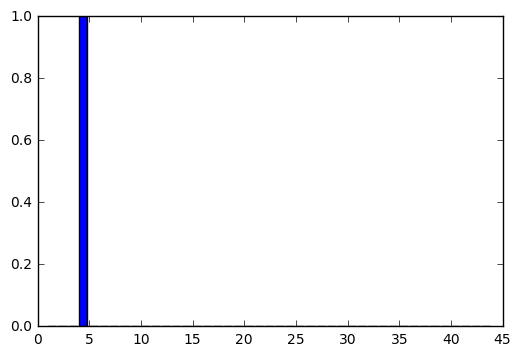

In [21]:
show_sign_at_index(17, classifications=streetview_classifications, images=streetview_signs)

## <font color='red'> #3: Correct Classification: No passing for vehicles over 3.5 metric tonnes
</font>

<font color='red'>Something to note with the classification below, is the top 5 classifications.  It's encouraging to see that the "no passing" sign (which is visually similar to the "no passing for vehicles over 3.5 metric tonnes" sign) was it's second choice.
</font>

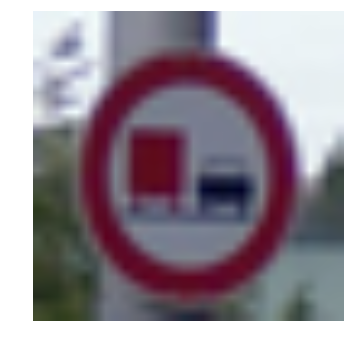

1: No passing for vechiles over 3.5 metric tons
2: No passing
3: No entry
4: Stop
5: End of no passing by vechiles over 3.5 metric tons


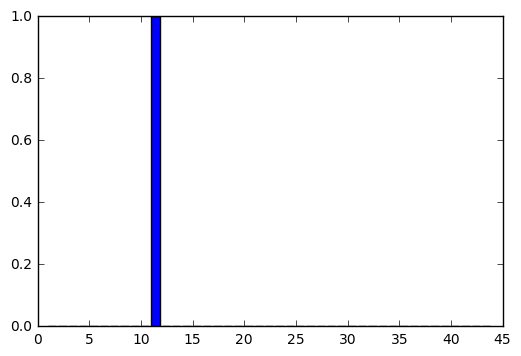

In [22]:
show_sign_at_index(18, classifications=streetview_classifications, images=streetview_signs)

## <font color='red'> #4: Uncertain Classification: Double Curve
</font>

<font color='red'>
The classifier was rather uncertain about the classification below as a double curve - and rightly so. At low definition, the sign is very similar to a "right of way at next intersection" sign.  A possible solution, as mentioned before, might be to train the model on higher definition images.
</font>

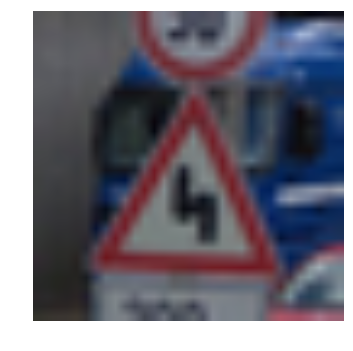

1: Double curve
2: Right-of-way at the next intersection
3: Beware of ice/snow
4: Slippery road
5: Wild animals crossing


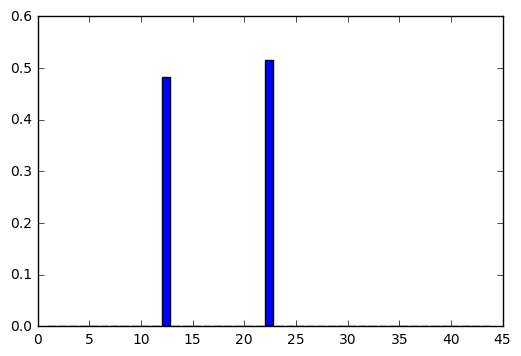

In [23]:
show_sign_at_index(19, classifications=streetview_classifications, images=streetview_signs)

## <font color='red'> #4: Misclassification: Traffic Signals
</font>

<font color='red'>
The sign below was unfortunately classified as a general caution sign. What is encouraging - nontheless - is that "Traffic Signals" was its second choice. 
<br><br>
In the diagnostics we see that the mistake is Sermanet's fault.  This might be due to Sermanet being trained on black and white images (in which case the 3 traffic sign dots might melt together to form an exclamation mark). Both increasing the definition of the photos, using higher quality or modifying Sermanet to use color images might be a possible solution to the problem.
</font>

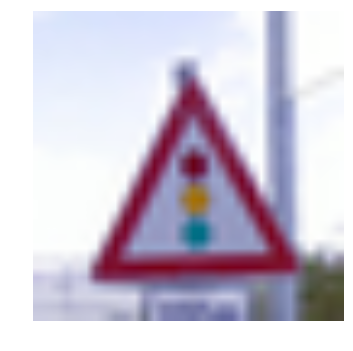

1: General caution
2: Traffic signals
3: Road narrows on the right
4: Pedestrians
5: Children crossing


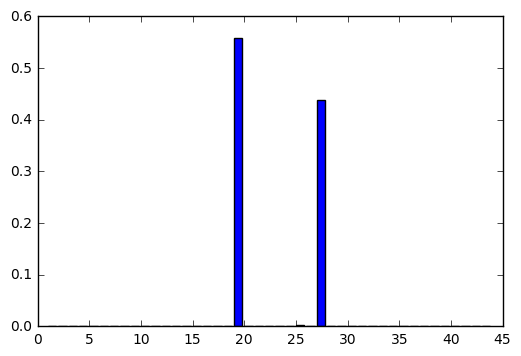

In [24]:
show_sign_at_index(21, classifications=streetview_classifications, images=streetview_signs)

In [25]:
## Diagnostics: We try see how each individual model in the ensemble classified the example, 
# in order to label the problematic model.

with tf.Session(graph = g1) as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    saver.restore(sess, "./SERMANET.ckpt")
    gray_image = [rgb_to_normalized_gray(streetview_signs[21])]
    
    prediction = sess.run(EB_prediction, feed_dict={EB_x: gray_image, EB_keep_prob:1.})
        
    print("SERMANET prediction:  "+sign_names[str(np.argmax([prediction]))])
        
with tf.Session(graph = g2) as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    saver.restore(sess, "./ALEXNET.ckpt")
    
    prediction = sess.run(AN_prediction, feed_dict={AN_x:[streetview_signs[21]], AN_keep_prob: 1.})
    
    print("ALEXNET prediction:  "+sign_names[str(np.argmax([prediction]))])

SERMANET prediction:  General caution
ALEXNET prediction:  Traffic signals


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

<font color='red'>
One would expect the model to perform slightly worse on the new images than those from the set it was trained on, simply because it's an entirely different datasource taken with a different camera, and from entirely different angles (My candidate images were taken from Google StreetView, which means the camera was mounted on top of the car, and we would expect the images to be much more distorted than those from a front-mounted, standard camera).
<br><br>
However, the model performed well and seems to have learned the features of the traffic signs (and not the subtle condition differences), which is great.  I validated this by also using a standard online sign dataset (which contains no distortion and no "outside effects") and still the model performed well, correctly classifying each of the images. This tells us that the model was able to capture the features of the traffic signs and not overfit (too severely) to the data it was trained with.
</font> 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

<font color='red'>
The model seems to be very confident about the top 1 class, even when it's classified incorrectly - which is slightly worrying.  We would want the model to be less certain of the incorrect classes and at least attach some probability to the correct class.  In those instances where the model classified the sign incorrectly, the sign did appear in the top 5 classifications - for the most part.
<br>
Further work on this model should be to try and further reduce overfitting (and learn more sign features), in order to see a more "normally spread" probability distribution over images that are very hard to classify.
</font> 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.